## Computing CO cross section using ExoMol

This tutorial demonstrates how to compute the opacity of CO using ExoMol step by step.

In [1]:
from exojax.spec.lpf import auto_xsection
from exojax.spec import SijT, doppler_sigma,  gamma_natural
from exojax.spec.exomol import gamma_exomol
from exojax.spec import moldb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

First of all, set a wavenumber bin in the unit of wavenumber (cm-1).
Here we set the wavenumber range as $1000 \le \nu \le 10000$ (1/cm) with the resolution of 0.01 (1/cm). 

We call moldb instance with the path of exomole files.

In [2]:
# Setting wavenumber bins and loading HITRAN database
nus=np.linspace(1000.0,10000.0,900000,dtype=np.float64) #cm-1
emf='~/exojax/data/CO/12C-16O/Li2015'
mdbCO=moldb.MdbExomol(emf,nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states


Define molecular weight of CO ($\sim 12+16=28$), temperature (K), and pressure (bar).
Also, we here assume the 100 % CO atmosphere, i.e. the partial pressure = pressure.  

In [3]:
Mmol=28.010446441149536 # molecular weight
Tfix=1000.0 # we assume T=1000K
Pfix=1.e-3 # we compute P=1.e-3 bar

partition function ratio $q(T)$ is defined by 

$q(T) = Q(T)/Q(T_{ref})$; $T_{ref}$=296 K

Here, we use the partition function from the interpolation of partition function

In [4]:
qt=mdbCO.qr_interp(Tfix)

Let us compute the line strength S(T) at temperature of Tfix.

$S (T;s_0,\nu_0,E_l,q(T)) = S_0 \frac{Q(T_{ref})}{Q(T)} \frac{e^{- h c E_l /k_B T}}{e^{- h c E_l /k_B T_{ref}}} \frac{1- e^{- h c \nu /k_B T}}{1-e^{- h c \nu /k_B T_{ref}}}= q_r(T)^{-1} e^{ s_0 - c_2 E_l (T^{-1} - T_{ref}^{-1})}  \frac{1- e^{- c_2 \nu_0/ T}}{1-e^{- c_2 \nu_0/T_{ref}}}$

$s_0=\log_{e} S_0$ : logsij0

$\nu_0$: nu_lines

$E_l$ : elower

Why the input is $s_0 = \log_{e} S_0$ instead of $S_0$ in SijT? This is because the direct value of $S_0$ is quite small and we need to use float32 for jax.  

In [5]:
Sij=SijT(Tfix,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

Then, compute the Lorentz gamma factor (pressure+natural broadening)

$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning 

$\gamma^p_L = \alpha_{ref}  ( T/T_{ref} )^{-n_{texp}} ( P/P_{ref}), $

and the natural broadening

$\gamma^n_L = \frac{A}{4 \pi c}$

In [6]:
gammaL = gamma_exomol(Pfix,Tfix,mdbCO.n_Texp,mdbCO.alpha_ref)\
+ gamma_natural(mdbCO.A) 

In [7]:
gamma_exomol(Pfix,Tfix,mdbCO.n_Texp,mdbCO.alpha_ref)

DeviceArray([3.1183732e-05, 3.8084123e-05, 3.8084123e-05, ...,
             3.8084123e-05, 3.1183732e-05, 3.1455678e-05], dtype=float32)

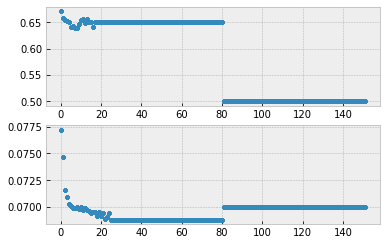

In [8]:
fig=plt.figure()
fig.add_subplot(211)
plt.plot(mdbCO.jlower,mdbCO.n_Texp,".")
fig.add_subplot(212)
plt.plot(mdbCO.jlower,mdbCO.alpha_ref,".")

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [9]:
# thermal doppler sigma
sigmaD=doppler_sigma(mdbCO.nu_lines,Tfix,Mmol)

Then, the line center...


In [10]:
#line center
nu0=mdbCO.nu_lines

Although it depends on your GPU, you might need to devide the computation into multiple loops because of the limitation of the GPU memory. Here we assume 30MB for GPU memory (not exactly, memory size for numatrix). 

In [11]:
xsv=auto_xsection(nus,nu0,sigmaD,gammaL,Sij,memory_size=30) #use 30MB GPU MEMORY for numax

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8257/8257 [02:48<00:00, 49.04it/s]


Plot it!

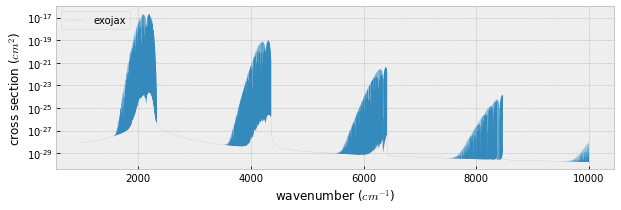

In [12]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(nus,xsv,lw=0.1,label="exojax")
plt.yscale("log")
plt.xlabel("wavenumber ($cm^{-1}$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.legend(loc="upper left")
plt.savefig("co_exomol.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

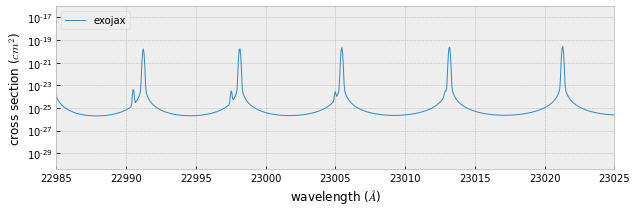

In [13]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
plt.plot(1.e8/nus,xsv,lw=1,label="exojax")
plt.yscale("log")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("cross section ($cm^{2}$)")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.savefig("co_exomol.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

### Important Note

Use float64 for wavenumber bin and line center.

Below, we see the difference of opacity between float64 case and float 32.

In [14]:
xsv_32=auto_xsection(np.float32(nus),np.float32(nu0),sigmaD,gammaL,Sij,memory_size=30) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8257/8257 [01:22<00:00, 100.29it/s]

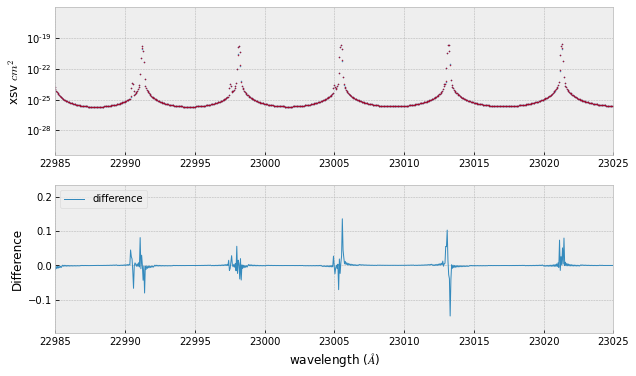

In [15]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(211)
plt.plot(1.e8/nus,xsv,".",lw=1,label="64",markersize=1)
plt.plot(1.e8/nus,xsv_32,".",lw=1,label="32",markersize=1)
plt.xlim(22985.,23025)
plt.yscale("log")
plt.ylabel("xsv $cm^{2}$")
ax=fig.add_subplot(212)
plt.plot(1.e8/nus,(xsv_32-xsv)/xsv,lw=1,label="difference")
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("Difference")
plt.xlim(22985.,23025)
plt.legend(loc="upper left")
plt.show()

We found ~ 10 % error when using float32 as an wavenumber and line center